### Deliverables 
1. EDA
2. Data Viz
3. Clustering
4. Silhouette + Inertia
5. 3 different DL models > base
6. 3 DL finetuned models > Keras Tuner
7. 3 ML different ML models > base
8. 3 ML finetuned models > GridsearchCV
9. Feature importance
10. top 10 most common important features on all 3 ML models
11. SHAP Forceplots
12. LIME
13. Saved dataset with the top 10 most common and significant features
14. Select the 2 best models (2 ML)
15. Conclusion and explain why these 2 models and why a DL model if able

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
import missingno as mn

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import NotFittedError

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

#metrics
from sklearn.metrics import(recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc)

#SHAP explainer
import shap

#LIME
import lime
import lime.lime_tabular

#widgets and dispaly
import ipywidgets as widgets
from IPython.display import display

#utilities
import pickle
import os
from tqdm import tqdm

c:\Users\ADMIN\anaconda3\envs\ds-gg\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Business goal
- Determine prices of properties based on the features

### Loading data

In [2]:
file_path = 'data/housing.csv'

df = pd.read_csv(file_path)

df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.20,47.34
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.36,47.51
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.16,47.44
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.37,47.57
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.18,47.73


# 1. EDA


In [3]:
num_record = df.shape[0]
num_features = df.shape[1]
data_types = df.dtypes

print(f'Number of records: {num_record}')
print(f'\nNumber of features {num_features}')
print(f'\nData types: \n{data_types}')

Number of records: 4944

Number of features 22

Data types: 
SalePrice               int64
SqFt1stFloor            int64
SqFtHalfFloor           int64
SqFt2ndFloor            int64
SqFtUpperFloor          int64
SqFtTotLiving           int64
SqFtTotBasement         int64
SqFtFinBasement         int64
SqFtGarageBasement      int64
SqFtGarageAttached      int64
DaylightBasement        int64
SqFtOpenPorch           int64
SqFtEnclosedPorch       int64
SqFtDeck                int64
BrickStone              int64
Bedrooms                int64
BathHalfCount           int64
Bath3qtrCount           int64
BathFullCount           int64
YrBuilt                 int64
Longitude             float64
Latitude              float64
dtype: object


<Axes: >

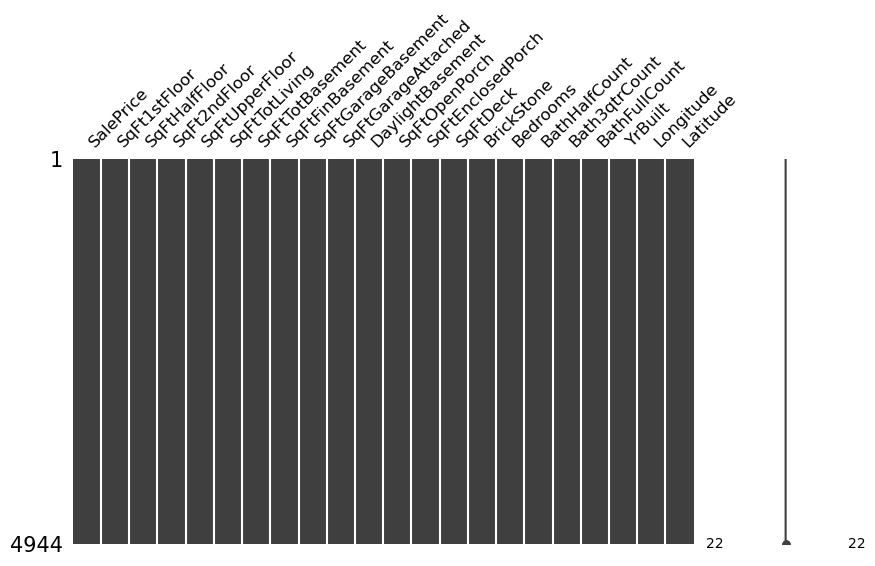

In [4]:
#visualize missing values
mn.matrix(df, figsize=(10,5), width_ratios=(5,1), fontsize=12)

In [5]:
duplicated_rows = df.duplicated().sum()
missing_values = df.isna().sum()

print(f'Number of duplicated rows: {duplicated_rows}')
print(f'\nNumber of missing values: \n{missing_values}')

Number of duplicated rows: 29

Number of missing values: 
SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64


In [6]:
statistics = df.describe()
print(f'\nStatistics: {statistics}')


Statistics:        SalePrice  SqFt1stFloor  SqFtHalfFloor  SqFt2ndFloor  SqFtUpperFloor  \
count    4944.00       4944.00        4944.00       4944.00         4944.00   
mean   664349.73       1175.50          51.76        349.31           26.99   
std    297808.04        446.40         174.46        544.63          115.33   
min     60000.00        260.00           0.00          0.00            0.00   
25%    450000.00        880.00           0.00          0.00            0.00   
50%    630550.00       1170.00           0.00          0.00            0.00   
75%    788612.50       1450.00           0.00        580.00            0.00   
max   1998000.00       3600.00        2000.00       3010.00         1220.00   

       SqFtTotLiving  SqFtTotBasement  SqFtFinBasement  SqFtGarageBasement  \
count        4944.00          4944.00          4944.00             4944.00   
mean         1935.21           595.07           334.27              102.42   
std           764.89           567.18    

In [7]:
def check_column_values(df):
    for column in df.columns:
        print(f'Unique Values in {column} column:')
        print(df[column].unique())
        print('\n')

check_column_values(df)

Unique Values in SalePrice column:
[ 400000  474250  667950 ...  934939  442000 1214950]


Unique Values in SqFt1stFloor column:
[1590 1390 1010  660 2310 1330 1420 1020 1120  770 1060 1730 1450  850
 1280 1110 1090 1820  980 1380 1130  500  360  430  730 1320 1710 1025
 1660 1500 1860  840 1650  960 1180 1230 1480 1430  920 2380  700  950
 1410 1140  900 1490  790  420 1560 1740 1300 1400 1053 1220 1100 1150
  690 1561 1250  810 1270 1210  880 1310  640 1030 1190  600 1050 1200
 1800  610  410  511  440 1840  800  830  890 1370  820 1260 1340 1711
  670  520 1640 1470 1080  984 1160  550 1780 2210  940 1040  990 1940
  910 2330 1920  570 1880 1670 1360 1610 2000 1690  390 1240 1350  710
 1680  860 1000 1193 1620 1580  590  780 1988  330 2790  540  400 1290
  580 1700 2010 1440 1540 1570 2110  480 2390  460 2580 2420 1170 2710
  930 1151 1070 1760 1720 1304 2260 2190 1930 2490 1179 1830  650 1890
  260 2360 1530  380  680  470  750 3030  870 1810  970 2120  620 1550
 1970  441 1900 151

In [8]:
num_cols = df.select_dtypes(include='number')

corr = num_cols.corr()
corr.style.background_gradient(cmap='coolwarm').format('{:.2f}')

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
SalePrice,1.00,0.18,0.10,0.37,0.07,0.51,0.19,0.20,0.02,0.09,0.09,0.21,0.00,0.20,0.08,0.26,0.17,0.19,0.29,0.13,0.07,0.41
SqFt1stFloor,0.18,1.00,-0.01,-0.08,-0.32,0.58,0.21,0.19,0.09,0.39,-0.03,0.19,-0.06,-0.05,0.08,0.45,0.02,0.09,0.19,-0.25,0.40,-0.12
SqFtHalfFloor,0.10,-0.01,1.00,-0.14,-0.04,0.07,0.06,-0.07,-0.08,-0.09,-0.15,0.03,0.03,-0.07,0.08,0.09,-0.01,-0.09,-0.03,-0.30,-0.11,0.07
SqFt2ndFloor,0.37,-0.08,-0.14,1.00,0.11,0.54,-0.30,-0.20,-0.13,0.36,-0.15,0.39,-0.00,-0.00,-0.11,0.30,0.29,0.08,0.50,0.59,0.18,-0.01
SqFtUpperFloor,0.07,-0.32,-0.04,0.11,1.00,-0.06,-0.20,-0.16,-0.06,-0.13,-0.13,-0.06,0.06,0.17,-0.04,-0.13,0.04,0.05,0.01,0.32,-0.17,0.09
SqFtTotLiving,0.51,0.58,0.07,0.54,-0.06,1.00,0.32,0.49,0.07,0.39,0.14,0.37,-0.03,0.12,0.04,0.66,0.25,0.28,0.53,0.24,0.32,-0.02
SqFtTotBasement,0.19,0.21,0.06,-0.30,-0.20,0.32,1.00,0.78,0.49,-0.28,0.55,-0.05,-0.01,0.17,0.17,0.24,-0.00,0.22,0.03,-0.24,-0.07,0.14
SqFtFinBasement,0.20,0.19,-0.07,-0.20,-0.16,0.49,0.78,1.00,0.25,-0.09,0.58,-0.03,-0.01,0.25,0.11,0.32,0.04,0.33,0.12,-0.02,0.03,0.06
SqFtGarageBasement,0.02,0.09,-0.08,-0.13,-0.06,0.07,0.49,0.25,1.00,-0.32,0.38,-0.09,-0.03,0.07,0.04,0.03,0.10,0.19,0.00,0.08,0.03,0.09
SqFtGarageAttached,0.09,0.39,-0.09,0.36,-0.13,0.39,-0.28,-0.09,-0.32,1.00,-0.19,0.28,-0.07,-0.09,-0.06,0.29,0.11,0.03,0.26,0.19,0.44,-0.22


array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'SqFt1stFloor'}>,
        <Axes: title={'center': 'SqFtHalfFloor'}>,
        <Axes: title={'center': 'SqFt2ndFloor'}>,
        <Axes: title={'center': 'SqFtUpperFloor'}>],
       [<Axes: title={'center': 'SqFtTotLiving'}>,
        <Axes: title={'center': 'SqFtTotBasement'}>,
        <Axes: title={'center': 'SqFtFinBasement'}>,
        <Axes: title={'center': 'SqFtGarageBasement'}>,
        <Axes: title={'center': 'SqFtGarageAttached'}>],
       [<Axes: title={'center': 'DaylightBasement'}>,
        <Axes: title={'center': 'SqFtOpenPorch'}>,
        <Axes: title={'center': 'SqFtEnclosedPorch'}>,
        <Axes: title={'center': 'SqFtDeck'}>,
        <Axes: title={'center': 'BrickStone'}>],
       [<Axes: title={'center': 'Bedrooms'}>,
        <Axes: title={'center': 'BathHalfCount'}>,
        <Axes: title={'center': 'Bath3qtrCount'}>,
        <Axes: title={'center': 'BathFullCount'}>,
        <Axes: title={'ce

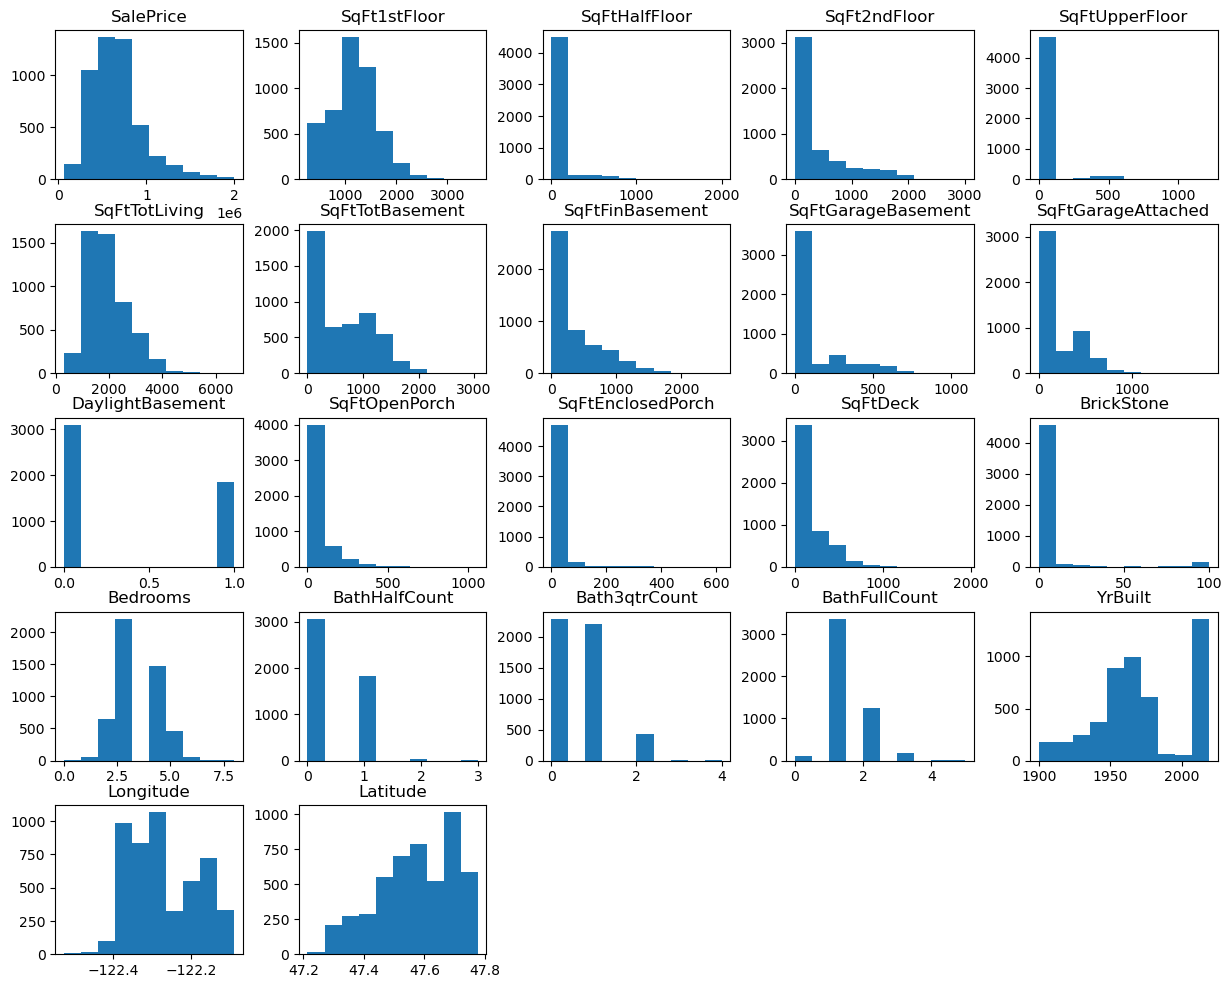

In [9]:
#Data Overview
df.hist(figsize=(15,12), bins=10, grid=False)

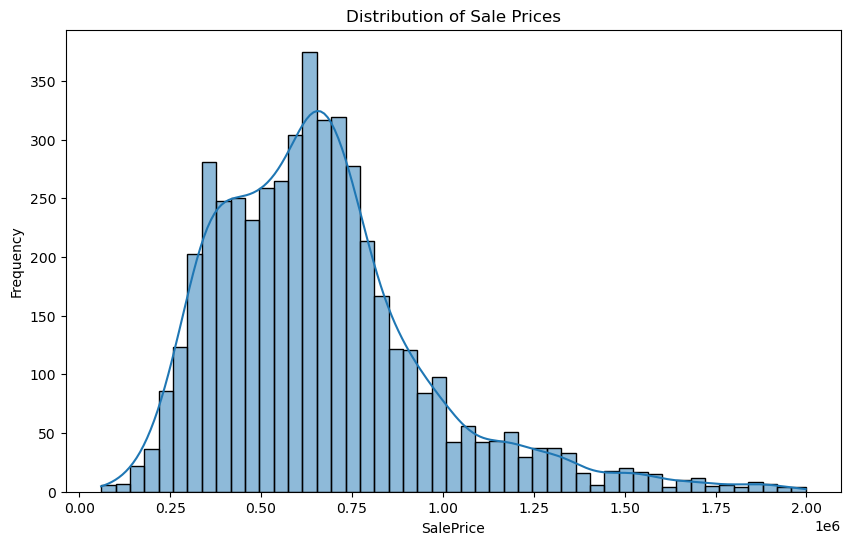

In [10]:
plt.figure(figsize=(10, 6))
sn.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [11]:
df.columns

Index(['SalePrice', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BrickStone',
       'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount',
       'YrBuilt', 'Longitude', 'Latitude'],
      dtype='object')

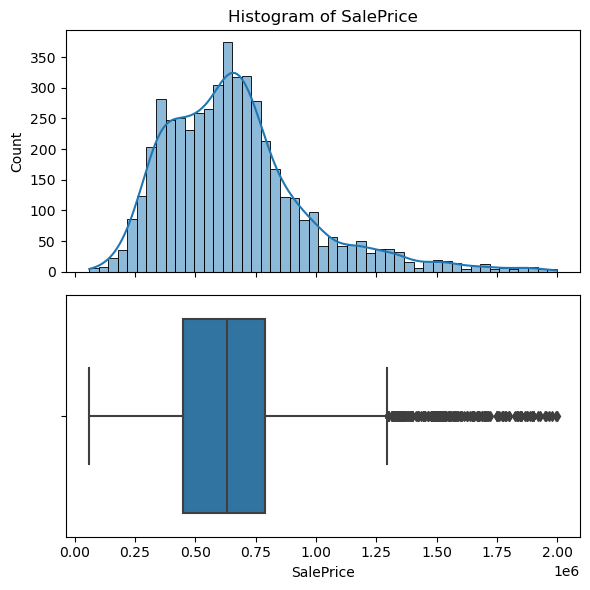

In [12]:
feature = 'SalePrice'

fig, axes = plt.subplots(nrows=2, figsize=(6,6), sharex=True)
sn.histplot(df[feature], bins='auto', kde=True, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title(f'Histogram of {feature}')

sn.boxplot(data=df, x=feature, ax=axes[1])
#remove grids
axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

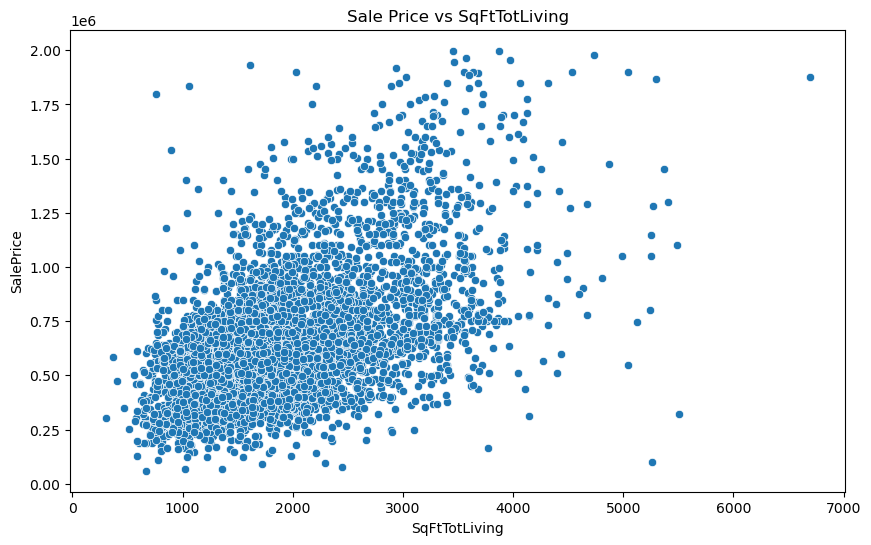

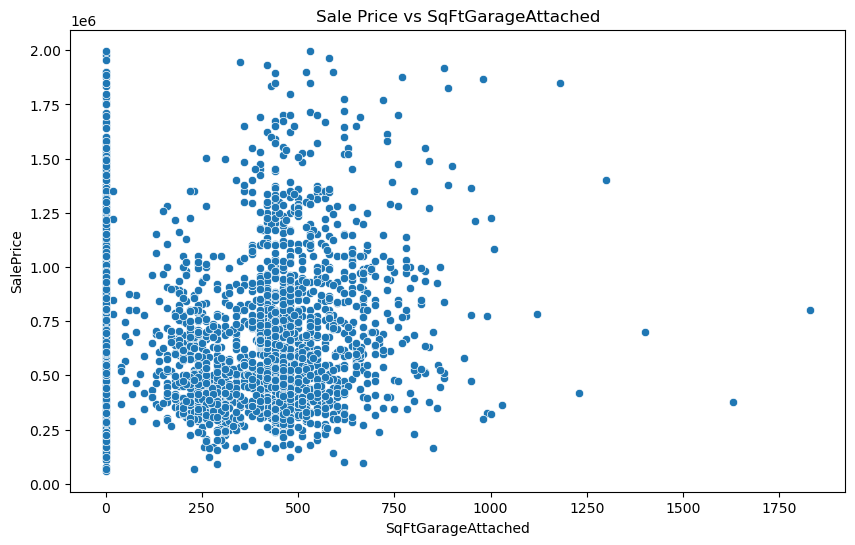

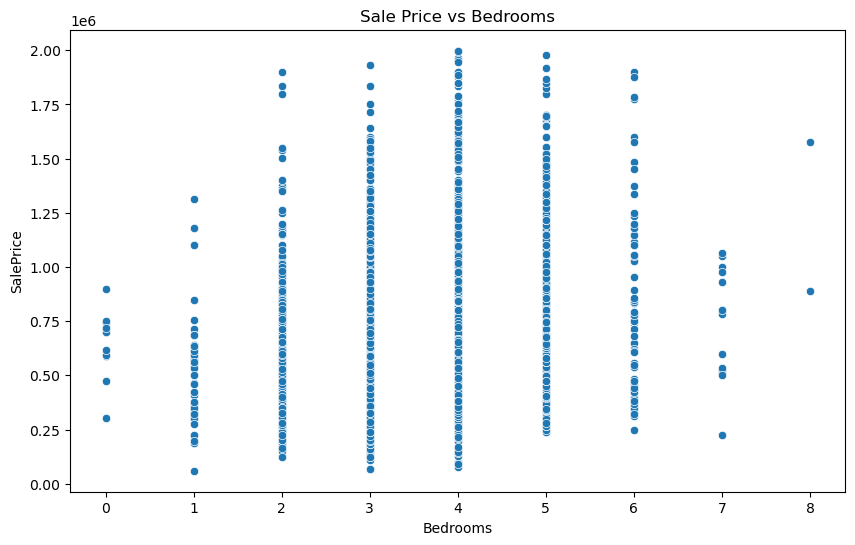

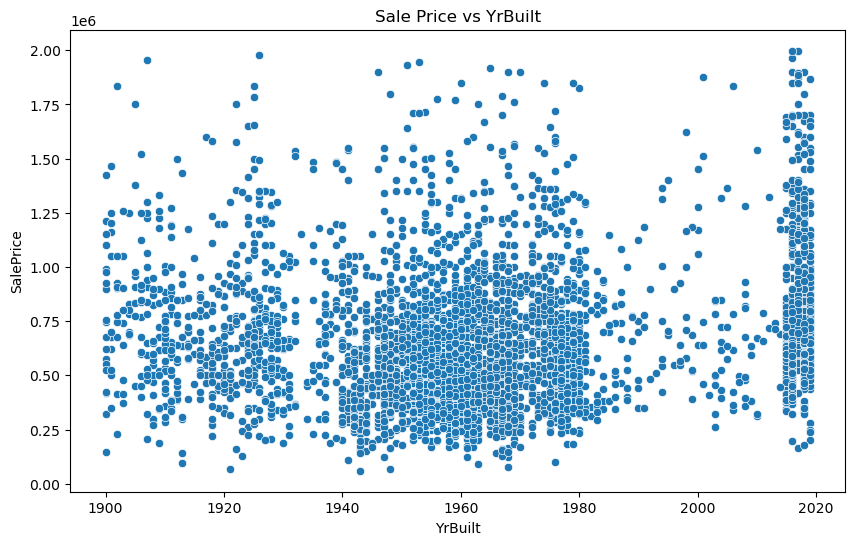

In [15]:
important_features = ['SqFtTotLiving', 'SqFtGarageAttached', 'Bedrooms', 'YrBuilt']
for feature in important_features:
    plt.figure(figsize=(10, 6))
    sn.scatterplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'Sale Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

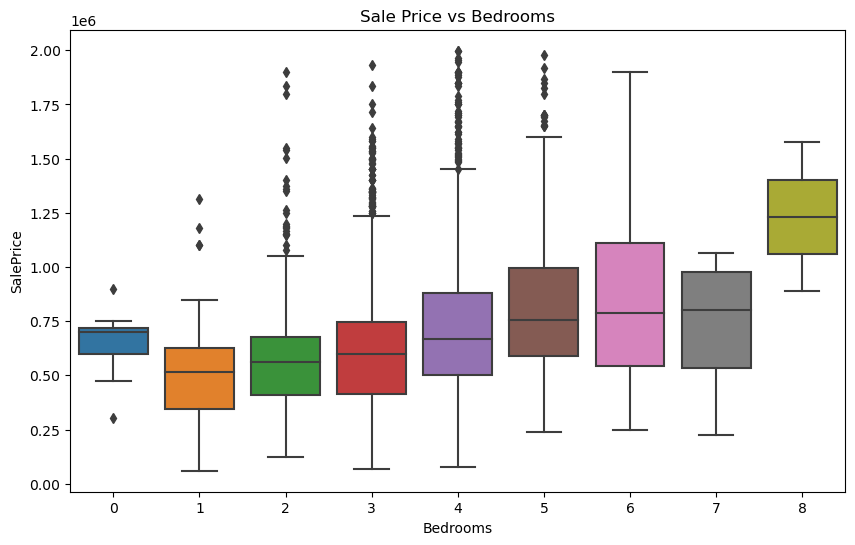

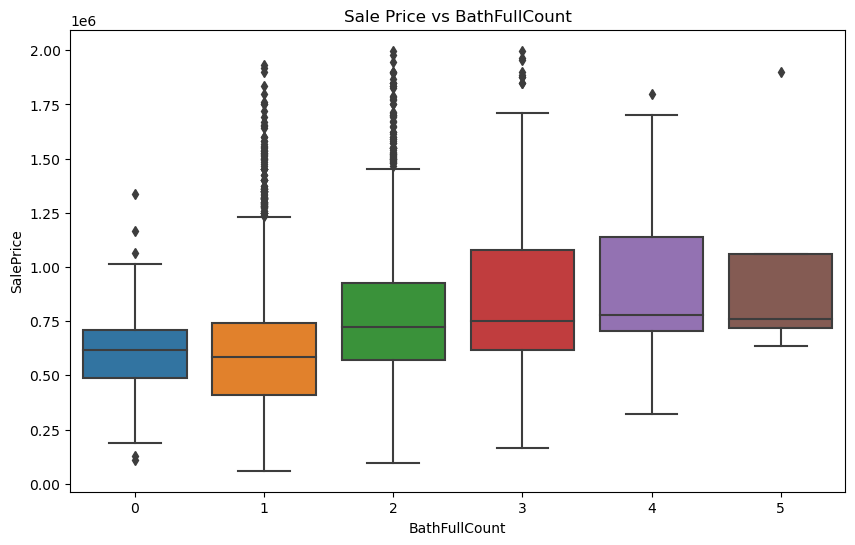

In [17]:
categorical_features = ['Bedrooms', 'BathFullCount']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sn.boxplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'Sale Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()